In [1]:
%matplotlib inline


# scikit-learn model cards

This guide demonstrates how you can use this package to create a model card on a
scikit-learn compatible model and save it.


## Imports
First we will import everything required for the rest of this document.



In [8]:
import os
import string
import pickle
import random
from pathlib import Path
from tempfile import mkdtemp, mkstemp

import pandas as pd
import sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
)
from sklearn.model_selection import HalvingGridSearchCV, train_test_split

from skops import hub_utils
from skops.card import Card, metadata_from_config

## Data
We load breast cancer dataset from sklearn.



In [3]:
X, y = load_breast_cancer(as_frame=True, return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
print("X's summary: ", X.describe())
print("y's summary: ", y.describe())

X's summary:         mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0.00000

## Train a Model
Using the above data, we train a model. To select the model, we use
:class:`~sklearn.model_selection.HalvingGridSearchCV` with a parameter grid
over :class:`~sklearn.ensemble.HistGradientBoostingClassifier`.



In [4]:
param_grid = {
    "max_leaf_nodes": [5, 10, 15],
    "max_depth": [2, 5, 10],
}

model = HalvingGridSearchCV(
    estimator=HistGradientBoostingClassifier(),
    param_grid=param_grid,
    random_state=42,
    n_jobs=-1,
).fit(X_train, y_train)
model.score(X_test, y_test)

0.9590643274853801

## Initialize a repository to save our files in
We will now initialize a repository and save our model



In [9]:
model_name = ''.join(random.choices(string.ascii_lowercase +
                             string.digits, k=6))

In [13]:
local_repo = 'models/skops-'+f'{model_name}'
os.mkdir(f'{local_repo}')

pkl_name = 'models/skops-'+f'{model_name}'+'.pkl'

with open(pkl_name, mode="bw") as f:
    pickle.dump(model, file=f)

hub_utils.init(
    model=pkl_name,
    requirements=[f"scikit-learn={sklearn.__version__}"],
    dst=local_repo,
    task="tabular-classification",
    data=X_test,
)

In [14]:
pkl_name

'models/skops-rm40n8.pkl'

## Create a model card
We now create a model card, and populate its metadata with information which
is already provided in ``config.json``, which itself is created by the call to
:func:`.hub_utils.init` above. We will see below how we can populate the model
card with useful information.



In [15]:
model_card = Card(model, metadata=metadata_from_config(Path(local_repo)))

## Add more information
So far, the model card does not tell viewers a lot about the model. Therefore,
we add more information about the model, like a description and what its
license is.



In [16]:
model_card.metadata.license = "mit"
limitations = "This model is not ready to be used in production."
model_description = (
    "This is a `HistGradientBoostingClassifier` model trained on breast cancer "
    "dataset. It's trained with `HalvingGridSearchCV`, with parameter grids on "
    "`max_leaf_nodes` and `max_depth`."
)
model_card_authors = "skops_user"
citation_bibtex = "**BibTeX**\n\n```\n@inproceedings{...,year={2020}}\n```"
model_card.add(
    **{
        "Citation": citation_bibtex,
        "Model Card Authors": model_card_authors,
        "Model description": model_description,
        "Model description/Intended uses & limitations": limitations,
    }
)

Card(
  model=HalvingGridSearchCV(estimator=H...des': [5, 10, 15]}, random_state=42),
  metadata.license=mit,
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'tabular-classification'],
  metadata.model_format=pickle,
  metadata.model_file=skops-rm40n8.pkl,
  metadata.widget={...},
  Model description=This is a `HistGrad...on `max_leaf_nodes` and `max_depth`.,
  Model description/Intended uses & lim... not ready to be used in production.,
  Model description/Training Procedure/...oring | | | verbose | 0 | </details>,
  Model description/Training Procedure/...</div></div></div></div></div></div>,
  Model Card Authors=skops_user,
  Citation=**BibTeX** ``` @inproceedings{...,year={2020}} ```,
)

## Add plots, metrics, and tables to our model card
Furthermore, to better understand the model performance, we should evaluate it
on certain metrics and add those evaluations to the model card. In this
particular example, we want to calculate the accuracy and the F1 score. We
calculate those using sklearn and then add them to the model card by calling
:meth:`.Card.add_metrics`. But this is not all, we can also add matplotlib
figures to the model card, e.g. a plot of the confusion matrix. To achieve
this, we create the plot using sklearn, save it locally, and then add it using
:meth:`.Card.add_plot` method. Finally, we can also add some useful tables to
the model card, e.g. the results from the grid search and the classification
report. Those can be added using :meth:`.Card.add_table`



Card(
  model=HalvingGridSearchCV(estimator=H...des': [5, 10, 15]}, random_state=42),
  metadata.license=mit,
  metadata.library_name=sklearn,
  metadata.tags=['sklearn', 'skops', 'tabular-classification'],
  metadata.model_format=pickle,
  metadata.model_file=skops-rm40n8.pkl,
  metadata.widget={...},
  Model description=This is a `HistGrad...on `max_leaf_nodes` and `max_depth`.,
  Model description/Intended uses & lim... not ready to be used in production.,
  Model description/Training Procedure/...oring | | | verbose | 0 | </details>,
  Model description/Training Procedure/...</div></div></div></div></div></div>,
  Model description/Evaluation Results=...| 0.959064 | | f1 score | 0.959064 |,
  Model description/Evaluation Results/Confusion Matrix='confusion_matrix.png',
  Model description/Evaluation Results/...arameter search results=Table(13x24),
  Model description/Evaluation Results/Classification report=Table(4x5),
  Model Card Authors=skops_user,
  Citation=**BibTeX** ``` @inp

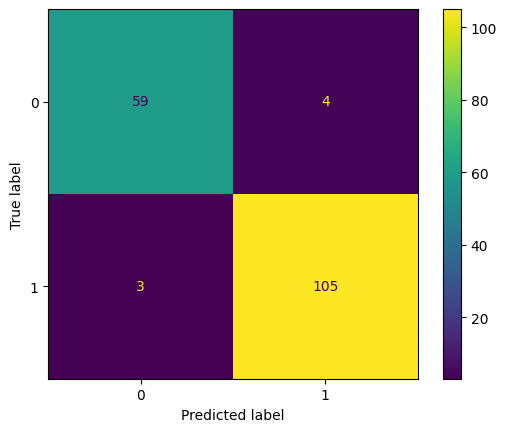

In [17]:
y_pred = model.predict(X_test)
eval_descr = (
    "The model is evaluated on test data using accuracy and F1-score with "
    "macro average."
)
model_card.add(**{"Model description/Evaluation Results": eval_descr})

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="micro")
model_card.add_metrics(**{"accuracy": accuracy, "f1 score": f1})

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()

disp.figure_.savefig(Path(local_repo) / "confusion_matrix.png")
model_card.add_plot(
    **{"Model description/Evaluation Results/Confusion Matrix": "confusion_matrix.png"}
)

cv_results = model.cv_results_
clf_report = classification_report(
    y_test, y_pred, output_dict=True, target_names=["malignant", "benign"]
)
# The classification report has to be transformed into a DataFrame first to have
# the correct format. This requires removing the "accuracy", which was added
# above anyway.
del clf_report["accuracy"]
clf_report = pd.DataFrame(clf_report).T.reset_index()
model_card.add_table(
    folded=True,
    **{
        "Model description/Evaluation Results/Hyperparameter search results": cv_results,
        "Model description/Evaluation Results/Classification report": clf_report,
    },
)

## Save model card
We can simply save our model card by providing a path to :meth:`.Card.save`.



In [18]:
model_card.save(Path(local_repo) / "README.md")